In [4]:
import numpy as np
from scipy.special import logsumexp
from scipy import stats
import matplotlib.pyplot as plt
import math

In [5]:
def calculate_covariance_matrix(X, Y=None):
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)


class GMM:
    def __init__(self, X, true_label, datasetname, k=2, iterations=500):
        self.k = k
        self.y = true_label
        self.X = X
        self.datasetname = datasetname
        self.parameters = []
        self.max_iterations = iterations
        self.last_likelihood = None
        self.sample_assignments = None
        self.responsibility = None
        
        n = np.shape(X)[0]
        self.priors = (1 / self.k) * np.ones(self.k)
        for i in range(self.k):
            params = {}
            params["mean"] = X[np.random.choice(range(n))]
            params["cov"] = self.calculate_covariance_matrix()
            self.parameters.append(params)
    
    def calculate_covariance_matrix(self):
        n_samples = np.shape(self.X)[0]
        covariance_matrix = (1 / (n_samples-1)) * (self.X - self.X.mean(axis=0)).T.dot(self.X - self.X.mean(axis=0))
        return np.array(covariance_matrix, dtype=float)

    def multivariate_gaussian(self, params):
        n_features = np.shape(self.X)[1]
        mean = params["mean"]
        covar = params["cov"]
        det = np.linalg.det(covar)
        likelihoods = np.zeros(np.shape(self.X)[0])
        for i, sample in enumerate(self.X):
            coeff = (1.0 / (math.pow((2.0 * math.pi), 1 / 2)* math.sqrt(det)))
            exponent = math.exp(-0.5 * (sample - mean).T.dot(np.linalg.pinv(covar)).dot((sample - mean)))
            likelihoods[i] = coeff * exponent
        return likelihoods

    def new_likelihoods(self):
        n_samples = np.shape(self.X)[0]
        likelihoods = np.zeros((n_samples, self.k))
        for i in range(self.k):
            likelihoods[:, i] = self.multivariate_gaussian(self.parameters[i])
        return likelihoods

    def expectation(self):
        weighted_likelihoods = self.new_likelihoods() * self.priors
        sum_likelihoods = np.sum(weighted_likelihoods, axis=1, keepdims=True)
        self.responsibility = weighted_likelihoods / sum_likelihoods
        self.sample_assignments = self.responsibility.argmax(axis=1)
        self.last_likelihood = np.max(self.responsibility, axis=1)

    def maximization(self):
        for i in range(self.k):
            resp = np.expand_dims(self.responsibility[:, i], axis=1)
            mean = (resp * self.X).sum(axis=0) / resp.sum()
            covariance = (self.X - mean).T.dot((self.X - mean) * resp) / resp.sum()
            self.parameters[i]["mean"], self.parameters[i]["cov"] = mean, covariance

        n_samples = np.shape(self.X)[0]
        self.priors = self.responsibility.sum(axis=0) / n_samples

    def different_likelihood(self, likelihoods):
        if len(likelihoods) < 2:
            return False
        diff = np.linalg.norm(likelihoods[-1] - likelihoods[-2])
        return diff <= 1e-8

    def plot_dataset(self):
        plt.scatter(self.X[:,0], self.X[:,1])
        plt.show()

    def predict(self):
        likelihoods = [np.inf]
        for _ in range(self.max_iterations):
            self.expectation()
            self.maximization()
            likelihoods.append(self.last_likelihood)
            
            if self.different_likelihood(likelihoods):
                break
        print(len(likelihoods))
        return self.sample_assignments

    def plot_clustering(self):
        plt.scatter(x=self.X[:,0], y=self.X[:,1], c=self.sample_assignments, cmap="tab20", s=5)
        plt.title(self.datasetname[:-4] + " with k: " + str(self.k) )
        plt.show()


In [6]:
all_models = []
for datasetname in ["blobs.csv", "circle.csv", "tsnv.csv","moon.csv", "elliptical.csv"]:
    dataset_x = np.loadtxt(datasetname, delimiter=",", dtype=str)[1:,:].astype(np.float64)[:,:2]
    try:
        dataset_y = np.loadtxt(datasetname, delimiter=",", dtype=str)[1:,:].astype(np.float64)[:,2]
    except:
        dataset_y = None
    dataset_model = []
    print(datasetname + ":")
    for k in [1,5,10]:
        print("K: ", str(k))
        em = GMM(dataset_x, dataset_y, datasetname, k, iterations=30*k)
        assignment = em.predict()
        dataset_model.append(em)
    all_models.append(dataset_model)



blobs.csv:
K:  1
3
K:  5
39
K:  10
301
circle.csv:
K:  1
3
K:  5
151
K:  10
301
tsnv.csv:
K:  1
3
K:  5
151
K:  10
301
moon.csv:
K:  1
3
K:  5
151
K:  10
301
elliptical.csv:
K:  1
3
K:  5
35
K:  10
301


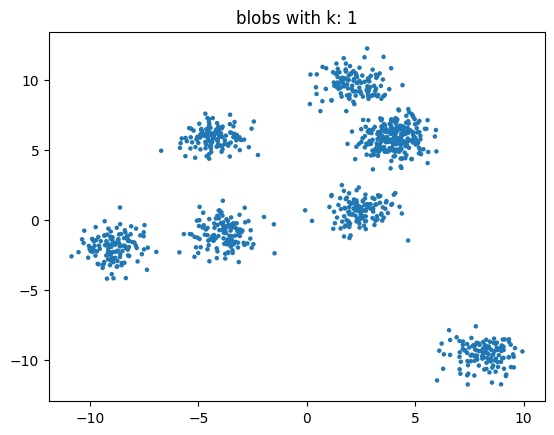

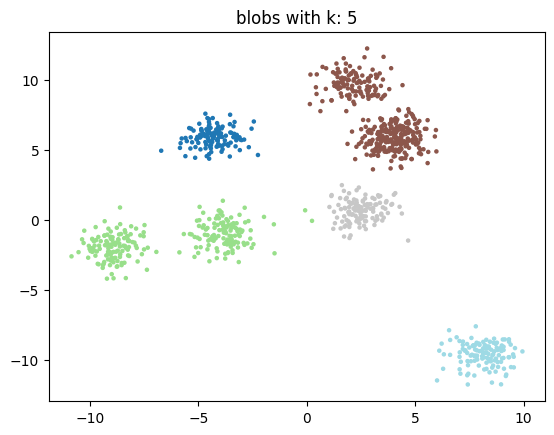

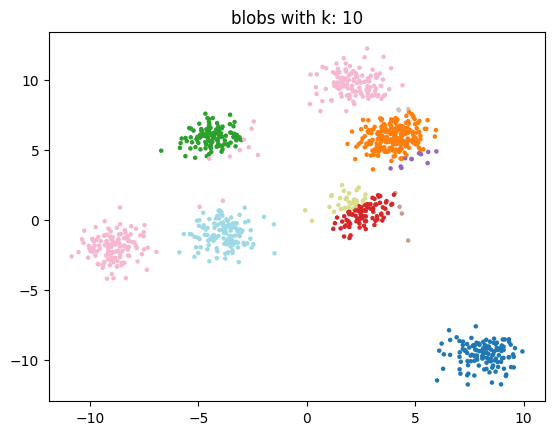

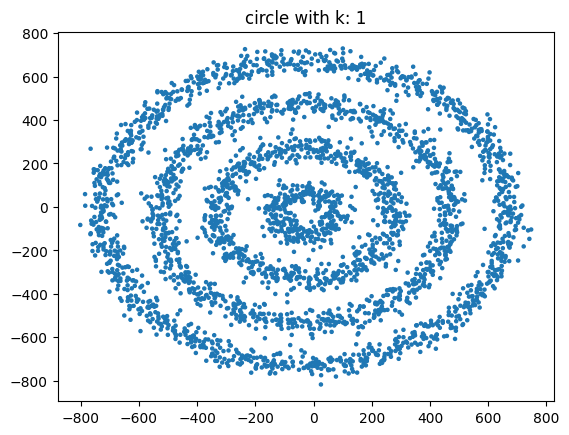

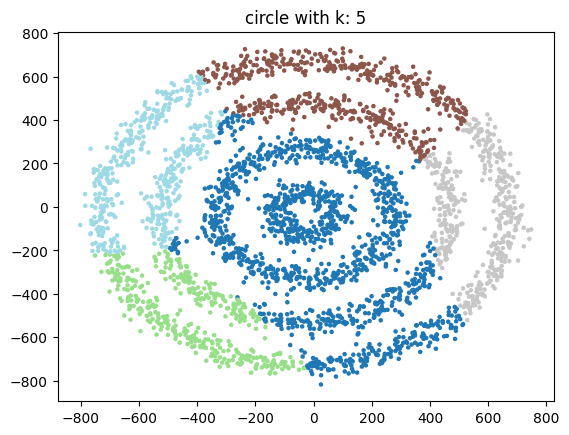

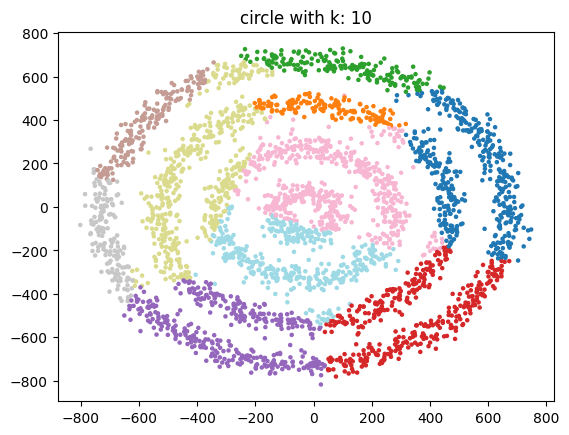

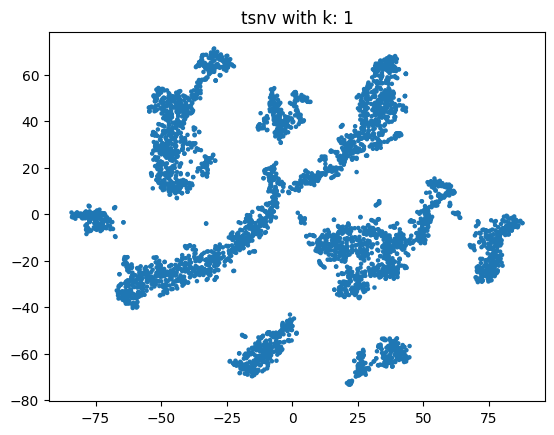

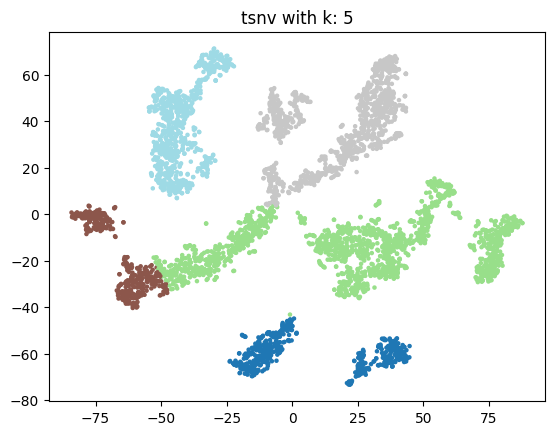

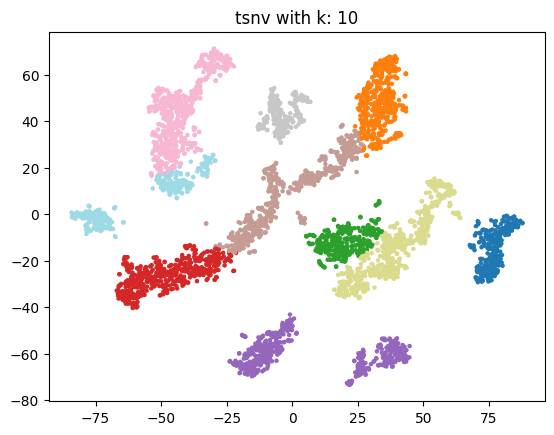

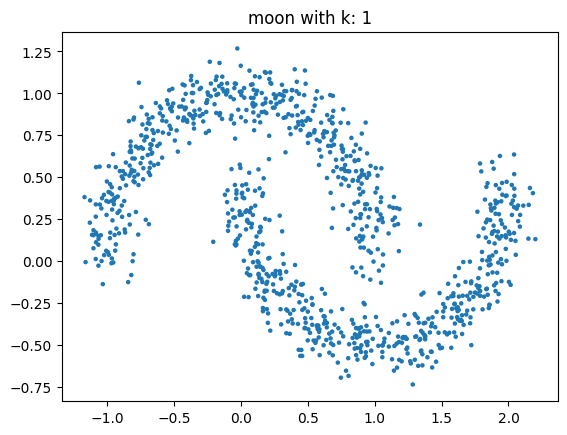

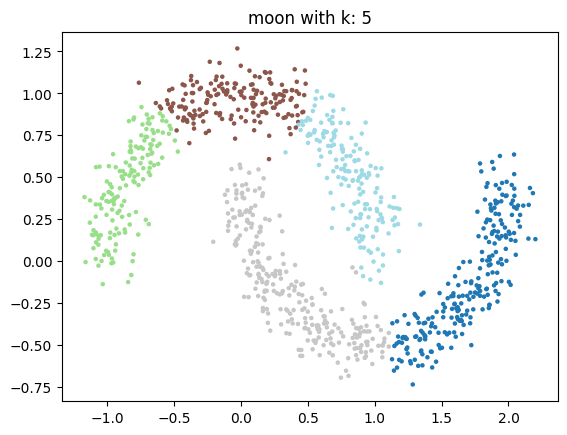

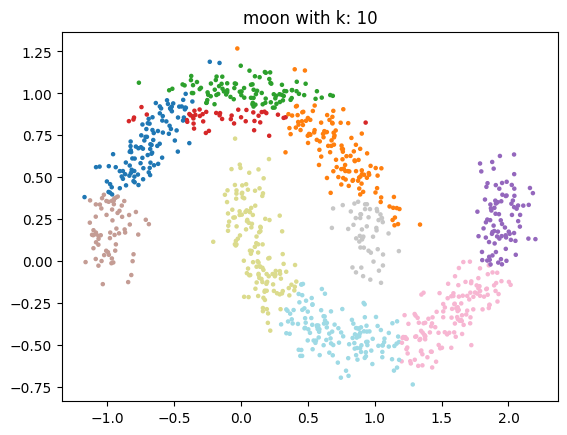

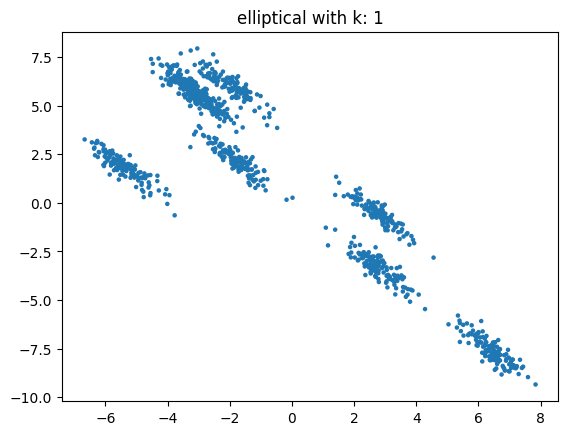

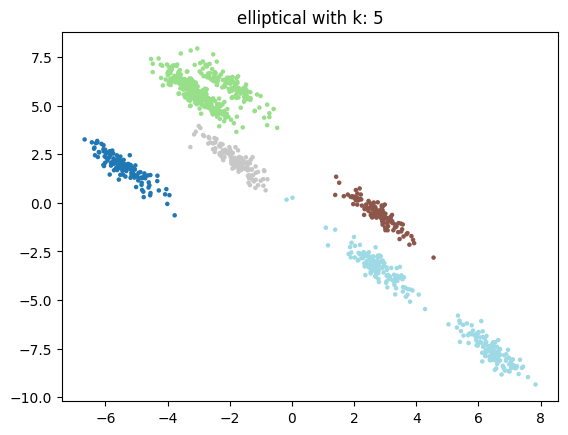

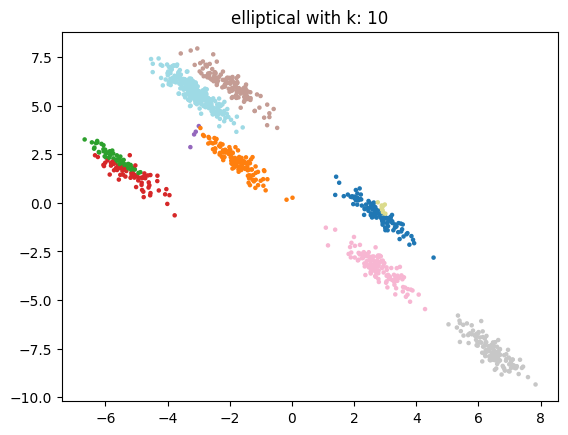

In [7]:
for dataset in all_models:
    for model in dataset:
        model.plot_clustering()

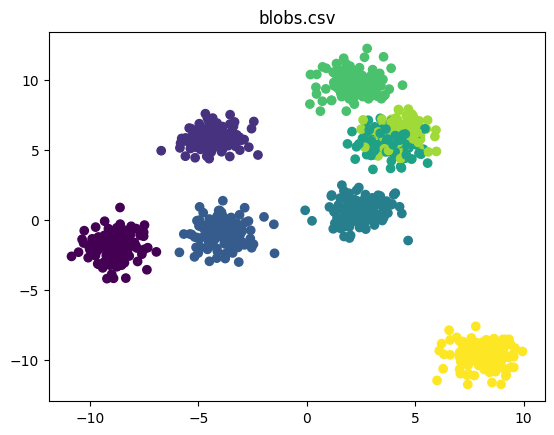

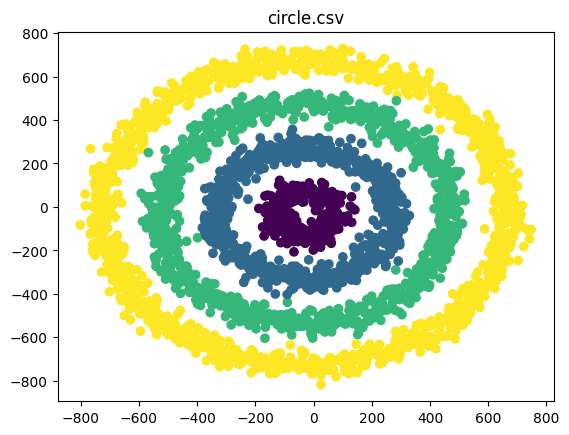

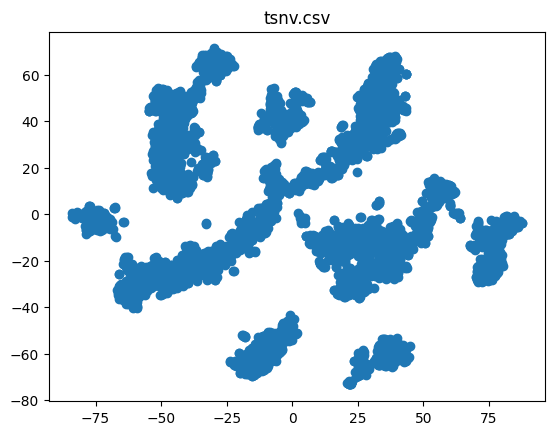

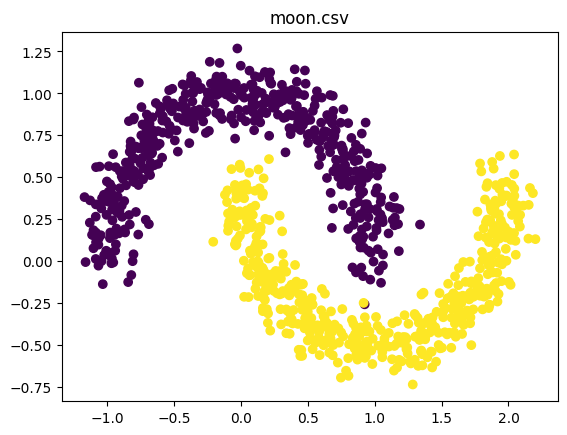

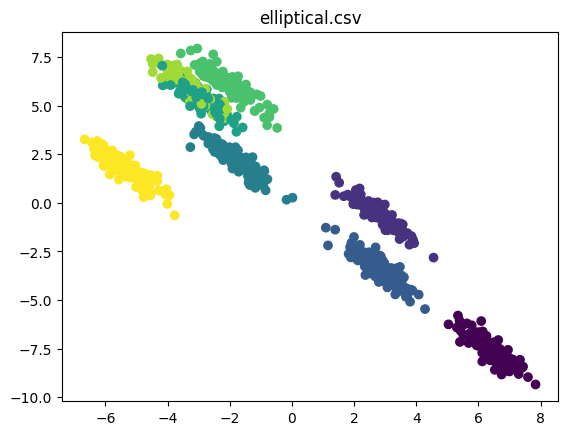

In [14]:
for datasetname in ["blobs.csv", "circle.csv", "tsnv.csv","moon.csv", "elliptical.csv"]:
    dataset_x = np.loadtxt(datasetname, delimiter=",", dtype=str)[1:,:].astype(np.float64)[:,:2]
    try:
        dataset_y = np.loadtxt(datasetname, delimiter=",", dtype=str)[1:,:].astype(np.float64)[:,2]
    except:
        dataset_y = None
    
    plt.scatter(dataset_x[:,0], dataset_x[:,1], c=dataset_y)
    plt.title(datasetname)
    plt.savefig(datasetname[:-4])

    plt.show()


In [ ]:
from sklearn import metrics
for dataset in all_models:
    for model in dataset:
        print(model.datasetname, model.k, metrics.calinski_harabasz_score(model.k, model.sample_assignments))

In [ ]:
from sklearn import metrics
for dataset in all_models:
    for model in dataset:
        print(model.datasetname, model.k, metrics.davies_bouldin_score(model.k, model.sample_assignments))